# Exploratory data analysis
This notebook contains code for generating selected, key results from the exploratory data analysis of the project. <br>
Keep in mind throughout that *DEPR_Control* is the shared control group of patients with depression and patients with schizophrenia.

## Imports and settings

In [15]:
# Data loading and preprocessing
from src import (
    load_joint_dataset,
    month_formatter,
    moving_average_smoothing,
    average_activity_data,
)

# General
import numpy as np
import pandas as pd

pd.options.mode.chained_assignment = None

# Plotting
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as md
from matplotlib.lines import Line2D
from matplotlib import rc

sns.set_style("whitegrid")
sns.set_context("paper")
sns.set(rc={"figure.figsize": (16, 9)})
rc("font", family="serif", size=18)

# Ignore warnings (specifically related to setting plot tick labels)
import warnings

warnings.filterwarnings("ignore")

## Import data

In [16]:
# Load all three datasets into one Pandas DataFrame
joint_df = load_joint_dataset()

2022-12-23 13:35:11.753 | INFO     | src.load_data:load_depresjon:36 - Loading depresjon
2022-12-23 13:35:19.982 | INFO     | src.load_data:load_psykose:63 - Loading psykose
2022-12-23 13:35:23.645 | INFO     | src.load_data:load_hyperaktiv:90 - Loading hyperaktiv


## 1. Number of data collection days 
Here we plot the distributions recording durations for each respective subject group. <br>
Observe especially the large differences between the ADHD dataset and the DEPR and SZ datsets. <br>
Furthermore, the distributions of recording durations do not seem to correspond with what is reported in the original papers.

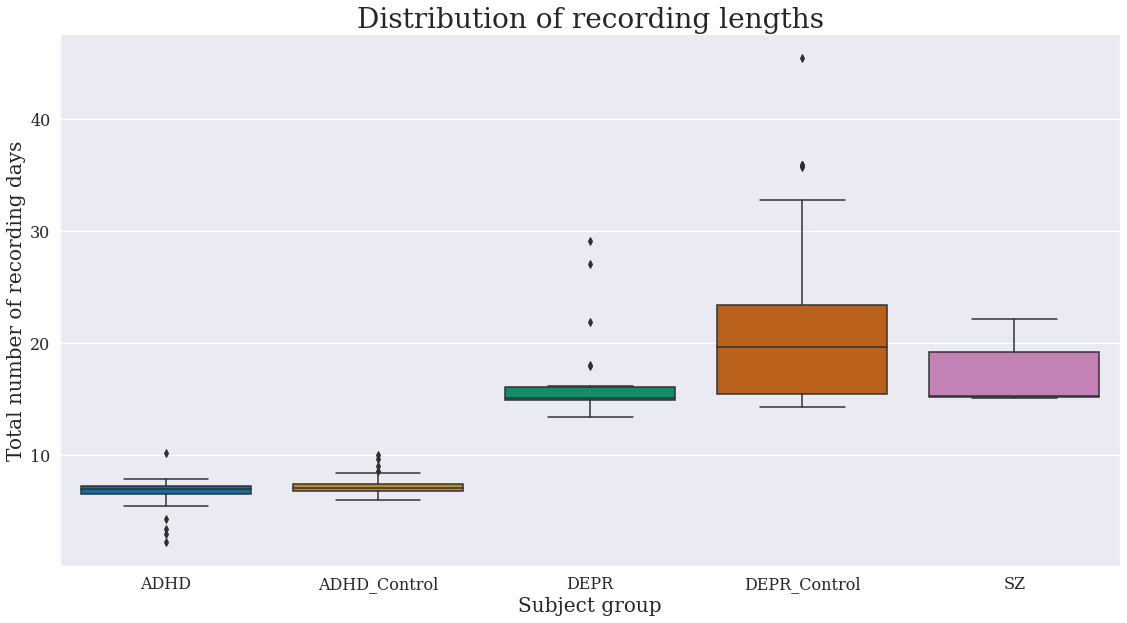

In [21]:
# Get the number of minutes recorded for each individual subject
counts = (
    joint_df.groupby(["condition", "subject_id"])
    .size()
    .reset_index(name="minutes of recording")
)

# Convert minutes counts to days
counts["days of recording"] = counts["minutes of recording"] / (60 * 24)

# Create boxplot of recording lengths within each subject group
fig, ax = plt.subplots()
sns.boxplot(
    data=counts, x="condition", y="days of recording", palette="colorblind", ax=ax
)
ax.set_xlabel("Subject group", fontsize=20)
ax.set_ylabel("Total number of recording days", fontsize=20)
ax.set_title("Distribution of recording lengths", fontsize=28)
ax.tick_params(axis="both", which="major", labelsize=16)
fig.tight_layout()

# Save and show plot
plt.savefig("fig/recording_length_distributions.png", dpi=1200)
plt.show()

Looking at the subject with the longest recording duration, the number of days recorded does not seem to correspond with the maximum reported in the original paper (*Depresjon*). In that paper, the longest recording duration was reported to be 20 days. A sanity check confirms that we are right.

In [19]:
counts[counts["days of recording"] == max(counts["days of recording"])]

,condition,subject_id,minutes of recording,days of recording
130,DEPR_Control,DEPR_control_3,65407,45.421528


## 2. Months of recording
In this subsection, we check for differences in which months of the year subjects have had recorded data. We do this to this since to check for potential seasonality effects, influencing the motor activity signals in various ways which could confound our results. <br>
We see clear unequal distributions here. SZ recorded exclusively in September through November. <br>
DEPR collected in Summer months while DEPR_control collected in Winter months. <br>
Difference between DEPR_Control and ADHD_Control in mean activity may be explained by different observation months. <br>
ADHD and ADHD_Control are somewhat evenly spread throughout the year.

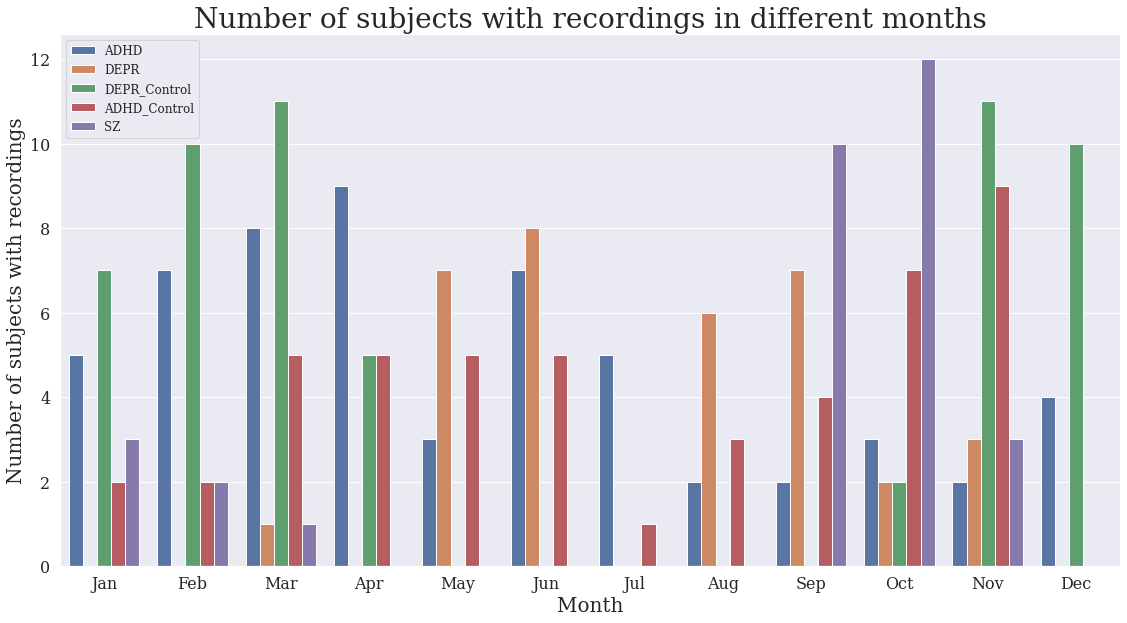

In [23]:
# Get month of recording for each individual recording
joint_df["month_of_recording"] = joint_df.timestamp.dt.month

# Compute which months each subject has recorded data in
subject_recording_months = set(
    joint_df[["subject_id", "condition", "month_of_recording"]].itertuples(index=False)
)
recording_months_df = pd.DataFrame(
    subject_recording_months, columns=["subject_id", "condition", "month"]
)

# Plot these distributions
fig, ax = plt.subplots()
sns.countplot(data=recording_months_df, x="month", hue="condition", ax=ax)
ax.set_xlabel("Month", fontsize=20)
ax.set_ylabel("Number of subjects with recordings", fontsize=20)
ax.set_title("Number of subjects with recordings in different months", fontsize=28)
ax.tick_params(axis="both", which="major", labelsize=16)
ax.xaxis.set_major_formatter(month_formatter)
plt.legend(loc="upper left", prop={"size": 12})
fig.tight_layout()

# Save and show plot
plt.savefig("fig/recording_length_distributions.png", dpi=1200)
plt.show()

## 3. Activity distributions across within diagnoses across months of recording

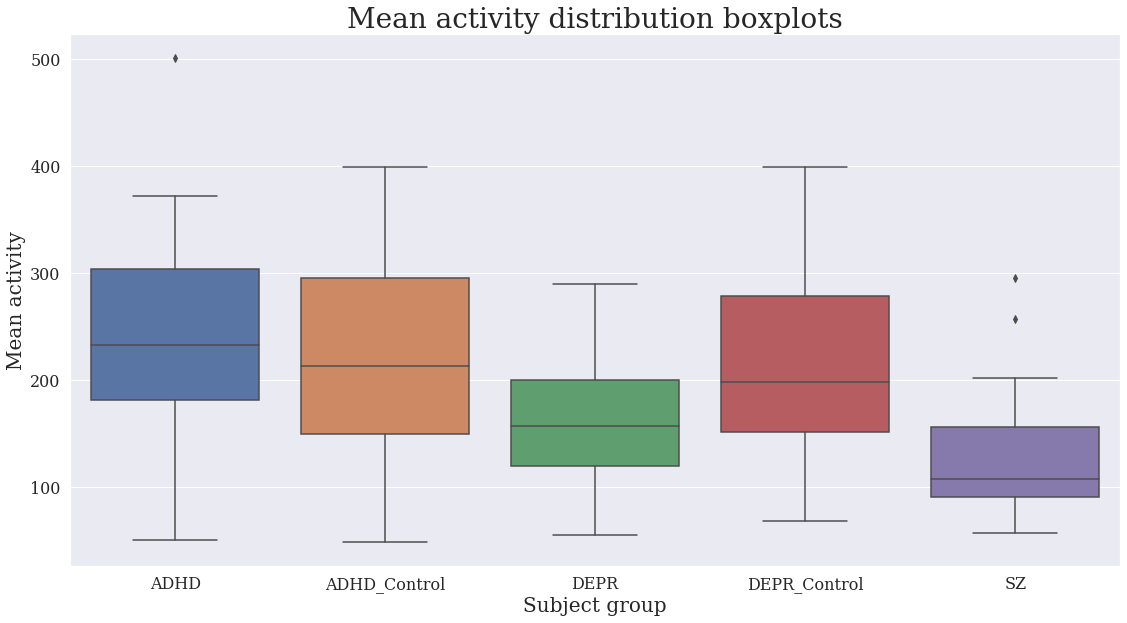

In [24]:
# Compute mean activities for each subject
mean_activities = joint_df.groupby(["subject_id", "condition"]).mean().reset_index()

# Plot mean activities
fig, ax = plt.subplots()
sns.boxplot(data=mean_activities, x="condition", y="activity", ax=ax)
ax.set_xlabel("Subject group", fontsize=20)
ax.set_ylabel("Mean activity", fontsize=20)
ax.set_title("Mean activity distribution boxplots", fontsize=28)
ax.tick_params(axis="both", which="major", labelsize=16)
fig.tight_layout()

# Show plot
plt.show()

## 4. Mean activity at given minute of the day

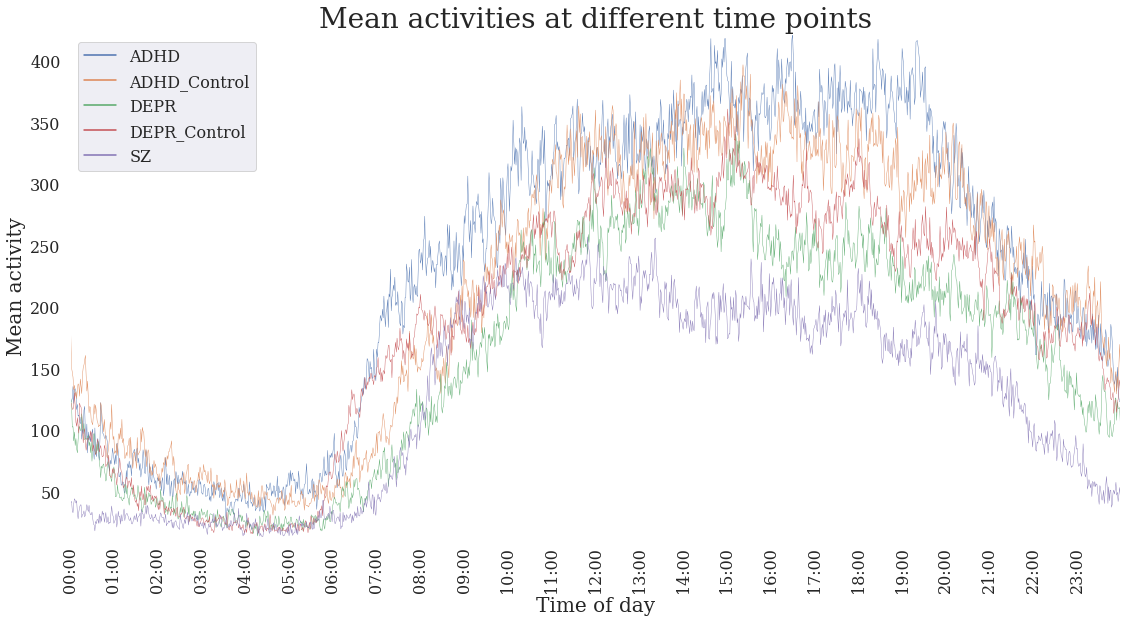

In [26]:
# Compute mean activity at a given minute of the day for each patient population
joint_df["time"] = joint_df.timestamp.dt.time
mean_activations = (
    joint_df.groupby(["condition", "time"]).mean("activity").reset_index()
)
mean_activations["time"] = mean_activations.time.astype(str)

# Plot mean activities in a day
fig, ax = plt.subplots()
sns.lineplot(
    data=mean_activations, x="time", y="activity", hue="condition", linewidth=0.4, ax=ax
)
fig.canvas.draw()
for label in ax.get_xticklabels():
    label_text = str(label.get_text())
    if label_text[3:5] == "00":
        label.set_visible(True)
    else:
        label.set_visible(False)
ax.set_xticklabels(sorted([x[:-3] for x in set(mean_activations.time)]))
plt.xticks(rotation=90)
ax.tick_params(axis="both", which="major", labelsize=16)
plt.legend(loc="upper left", prop={"size": 16})
ax.set_xlabel("Time of day", fontsize=20)
ax.set_ylabel("Mean activity", fontsize=20)
ax.set_title("Mean activities at different time points", fontsize=28)
ax.margins(x=0, y=0)
plt.tight_layout()

# Show plot
plt.show()

## 4. Distribution of activity signals
Just a quick check of the skewness of the respective magnitudes of each activity signal. Notice that large proportion of times at which activities are zero.

In [27]:
joint_df.activity.quantile([0.1, 0.25, 0.5, 0.75, 0.90, 0.95, 1.0])

0.10       0.0
0.25       0.0
0.50       7.0
0.75     225.0
0.90     609.0
0.95     911.0
1.00    8000.0
Name: activity, dtype: float64

## 5. Variance in activity levels for each subject
Here, we attempt to plot activity levels  across the different days that the subject has had their data recorded. These plots showcase how variant each subject's activity signals may be across different days within a given timeframe. As we can see, activity sequences are generally very variable, even for the same subject.

In [51]:
def plot_activities(master_df, subject_id, timeframe, remove_extremes_values=True):
    """Plots activities across days for 1 subject

    Args:
        master_df (Pandas DataFrame): Pandas DataFrame containing activity sequences for all subjects
        subject_id (str): ID of subject whose activity sequences are to be plotted
        timeframe (List[str]): A list containing two strings, respectively the start and the stop times of the subsequences to be plotted.
        remove_extremes_values (bool, optional): If set to True, removes values above the 99th percentile to make plotting more legible. Defaults to True.
    """
    # Filter out activity sequence for subject
    subject_df = master_df[master_df.subject_id == subject_id]

    # Get total number of days of recording for the subject
    days_of_recording = len(subject_df) / (60 * 24)

    # Remove extrem values
    if remove_extremes_values:
        subject_df["activity"] = subject_df.activity[
            subject_df.activity <= subject_df.activity.quantile(0.99)
        ]

    # Filter out recordings outside of the desired timefra
    subject_df["day"] = subject_df.timestamp.dt.date
    subject_df["time"] = subject_df.timestamp.dt.time
    subject_df["time"] = subject_df.time.astype(str)
    subject_df = subject_df[
        (subject_df.time >= timeframe[0]) & (timeframe[1] >= subject_df.time)
    ]

    # Get mean activities for each time point
    mean_activities = subject_df.groupby("time").mean("activity").reset_index()

    # Plot sequences
    fig, ax = plt.subplots(figsize=(16, 10))
    sns.lineplot(data=mean_activities, x="time", y="activity", color="b", ax=ax)
    day_groups = subject_df.groupby("day")
    for day_group in day_groups.groups:
        day_data = day_groups.get_group(day_group)
        sns.lineplot(data=day_data, x="time", y="activity", alpha=0.35, ax=ax)
    fig.canvas.draw()
    for label in ax.get_xticklabels():
        label_text = label.get_text()
        if label_text[3:5] == "00" or label_text[3:5] == "30":
            label.set_visible(True)
        else:
            label.set_visible(False)
    labels = sorted([x[:-3] for x in set(subject_df.time)])
    ax.set_xticklabels(labels)
    custom = [
        Line2D([], [], marker="_", color="b", linewidth=5),
        Line2D([], [], linewidth=0),
    ]
    plt.legend(
        custom,
        [
            "Mean motor activity",
            "Transparent lines display recordings\nfor each individual day",
        ],
        loc="upper right",
        prop={"size": 18},
    )
    ax.tick_params(axis="both", which="major", labelsize=16)
    plt.xticks(rotation=60, ha="right", rotation_mode="anchor")
    plt.xlabel("Time point", fontsize=20)
    plt.ylabel("Activity", fontsize=20)
    plt.suptitle(
        f"Activity for {subject_id}, {round(days_of_recording, 1)} days of recording",
        fontsize=28,
    )
    ax.margins(x=0, y=0)
    plt.tight_layout()

    # Show plot
    plt.savefig("fig/activity_variance_example.png", dpi=1200)
    plt.show()

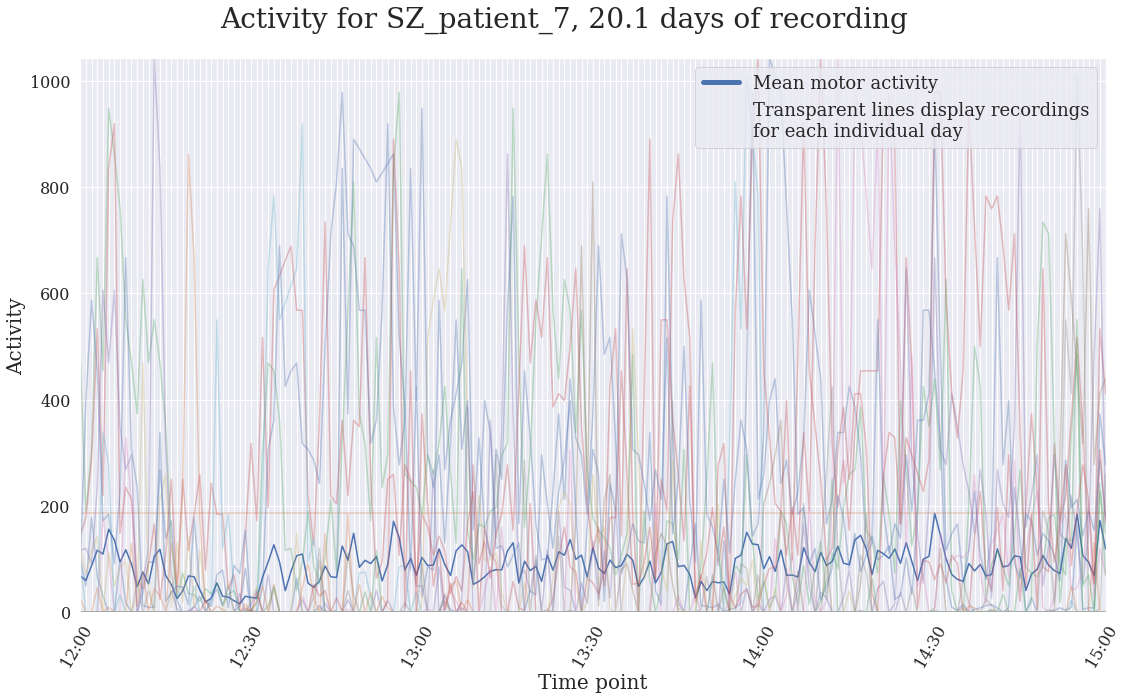

In [52]:
# Plot recordings from a subject
subject_ids = list(set(joint_df["subject_id"]))
subject_ids = [subject_id for subject_id in subject_ids if "SZ" in subject_id]
plot_activities(joint_df, subject_ids[-1], ("12:00:00", "15:00:00"))

# Save plot
# plt.savefig('fig/activity_variance_example.png', dpi=1200)

## 6. Smoothing and averaging

In [38]:
# Split joint df into subject-individual dfs
subject_groups = joint_df.groupby("subject_id")
subject_dfs = [subject_groups.get_group(group) for group in subject_groups.groups]

In [39]:
# Get df of random subject
subject_index = 20
subject_df = subject_dfs[subject_index]

# Get smoothed and averaged activity signals (k can be set different for smoothed and average signals)
k = 5
subject_df["activity_smoothed_5"] = moving_average_smoothing(subject_df["activity"], k)
average_df = average_activity_data(
    subject_df, "timestamp", "activity", ["subject_id", "condition"], k
)

# Subset datasetsd
n_subset = 240
subject_df = subject_df[:n_subset]
average_df = average_df[: n_subset // k + 1]

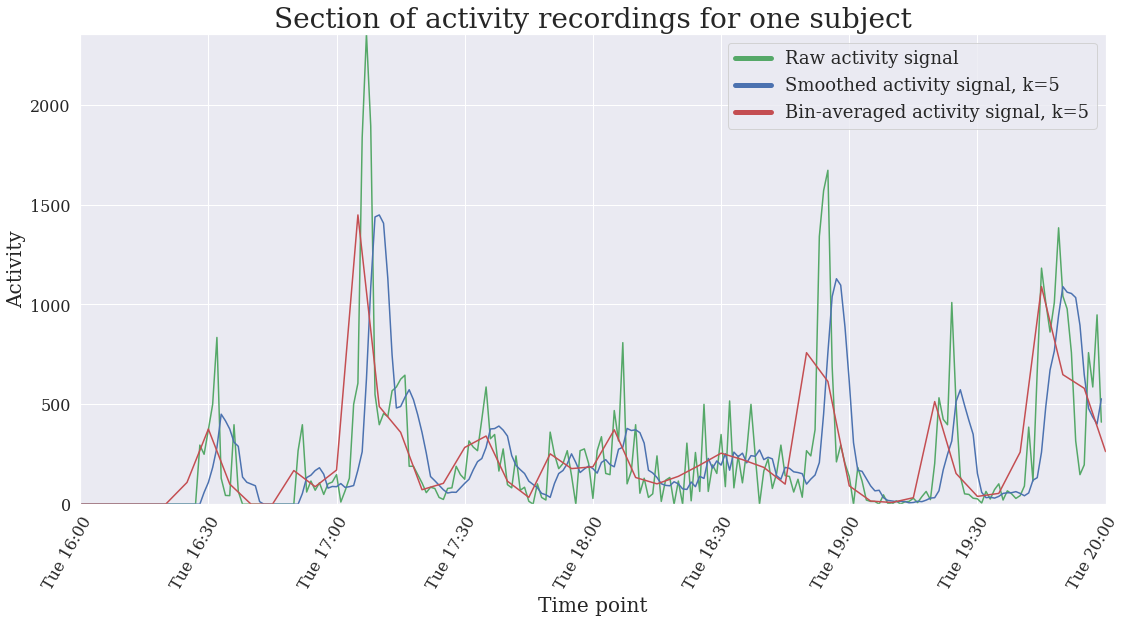

In [50]:
fig, ax = plt.subplots(figsize=(16, 9))
sns.lineplot(data=subject_df, x="timestamp", y="activity", color="g", ax=ax)
sns.lineplot(data=subject_df, x="timestamp", y="activity_smoothed_5", color="b", ax=ax)
sns.lineplot(data=average_df, x="timestamp", y="activity", color="r", ax=ax)

custom = [
    Line2D([], [], marker="_", color="g", linewidth=5),
    Line2D([], [], marker="_", color="b", linewidth=5),
    Line2D([], [], marker="_", color="r", linewidth=5),
]
plt.legend(
    custom,
    [
        "Raw activity signal",
        "Smoothed activity signal, k=5",
        "Bin-averaged activity signal, k=5",
    ],
    loc="upper right",
    prop={"size": 18},
)
plt.xticks(rotation=60, ha="right", rotation_mode="anchor")
ax.set_xlabel("Time point", fontsize=20)
ax.set_ylabel("Activity", fontsize=20)
ax.set_title("Section of activity recordings for one subject", fontsize=28)
ax.tick_params(axis="both", which="major", labelsize=16)
ax.xaxis.set_major_formatter(md.DateFormatter("%a %H:%M"))
ax.margins(x=0, y=0)
fig.tight_layout()

# Save and show plot
plt.savefig("fig/effects_of_smoothing_averaging.png", dpi=1200)
plt.show()

## 7. Weekday vs. weekend

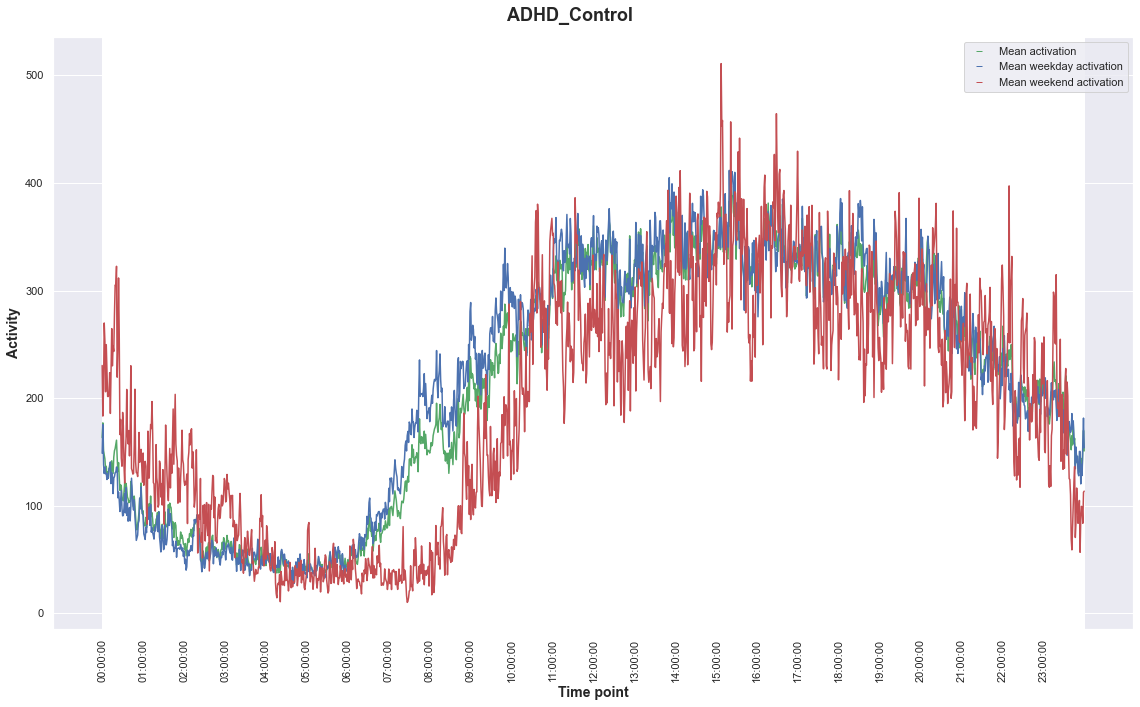

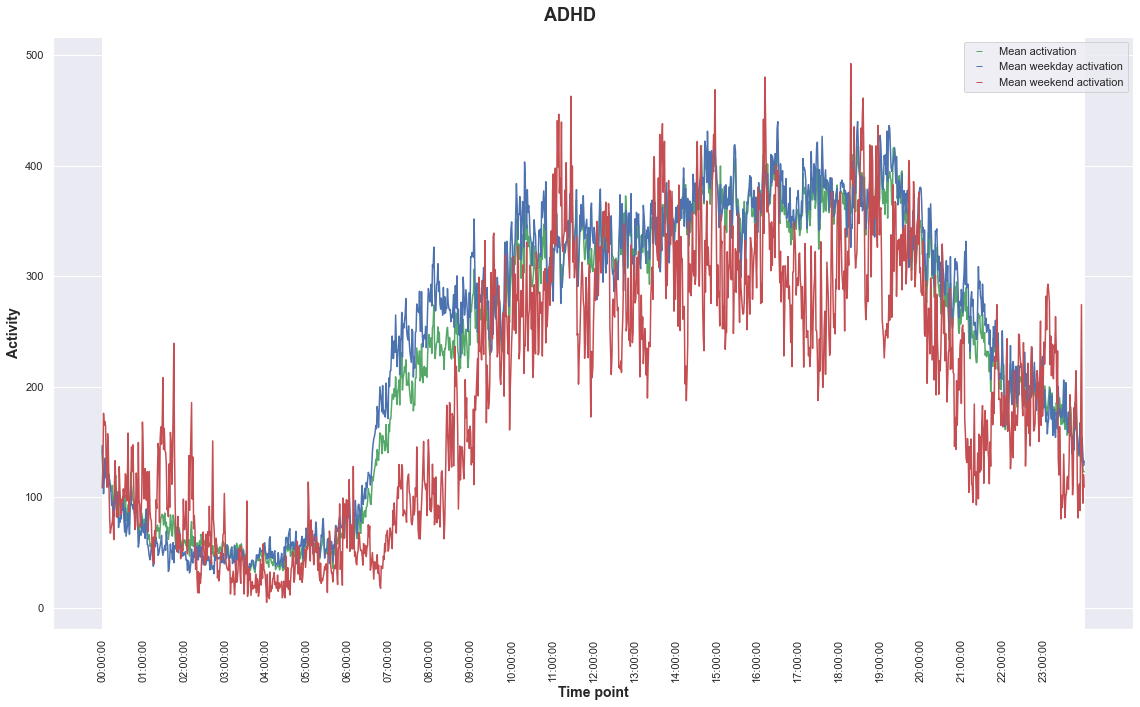

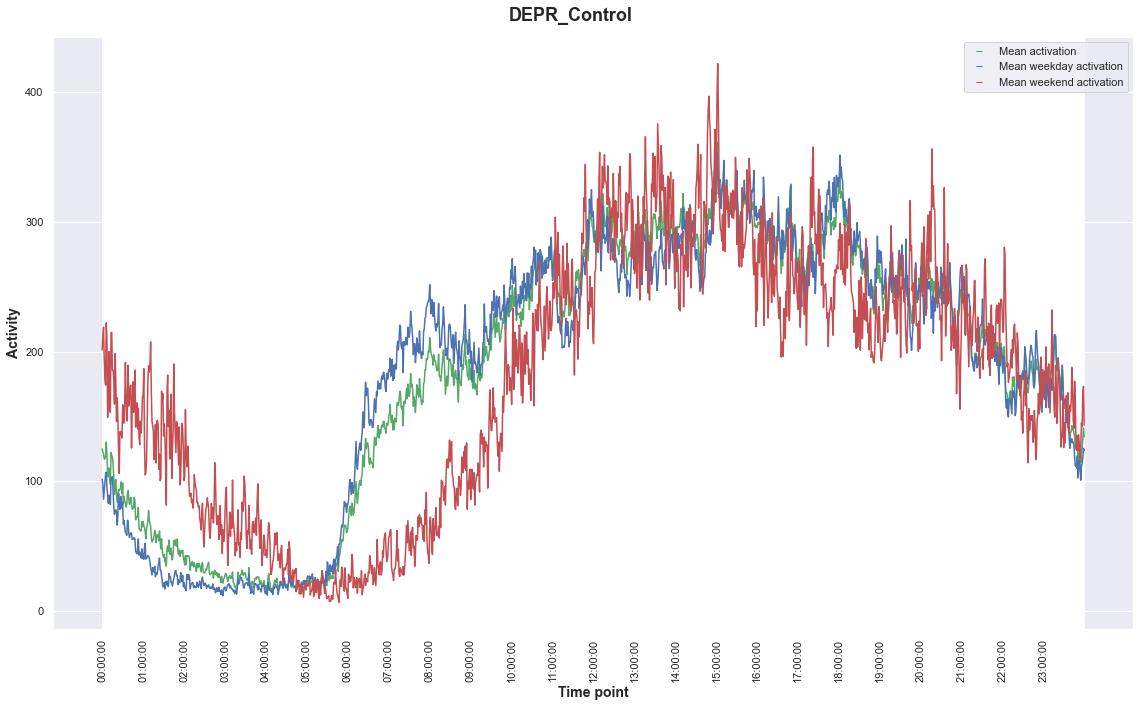

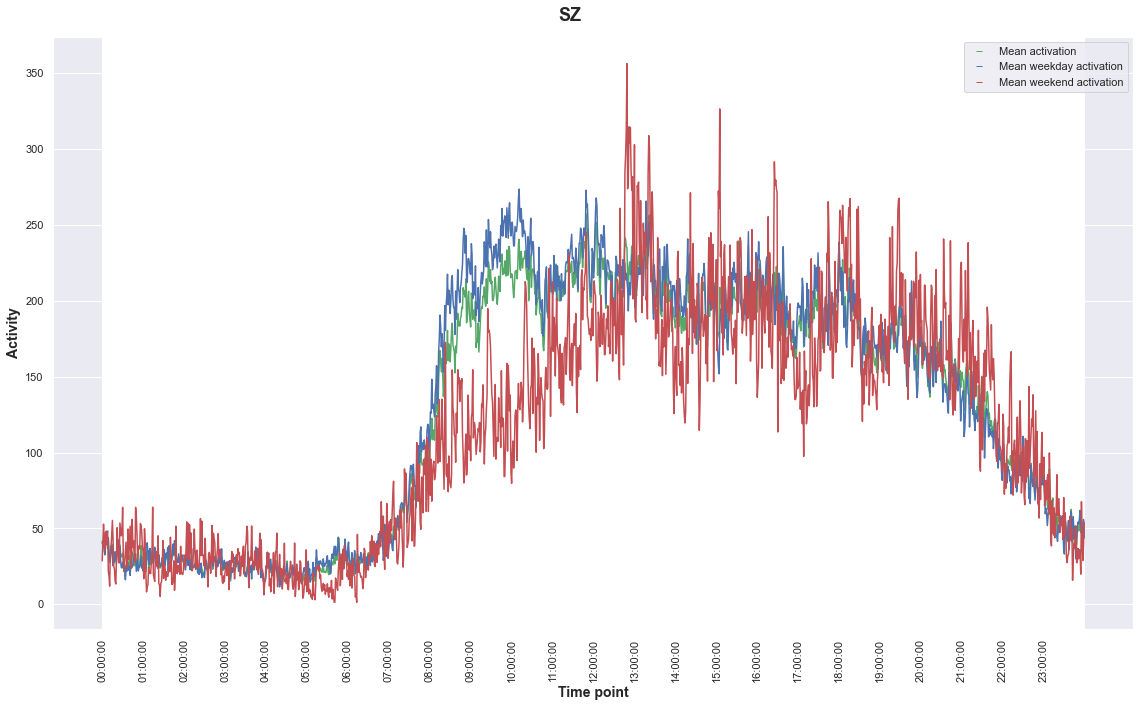

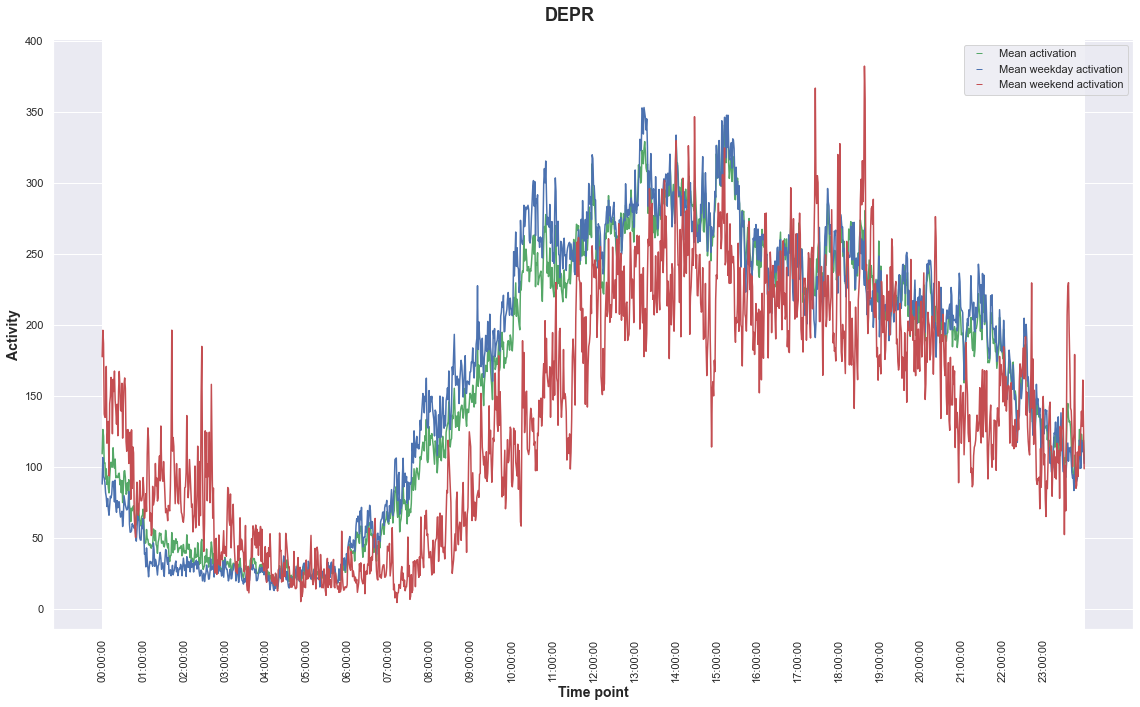

In [91]:
for condition in set(joint_df.condition):
    condition_df = joint_df[joint_df.condition == condition]

    condition_df["time"] = condition_df.timestamp.dt.time
    condition_df["time"] = condition_df.time.astype(str)

    mean_activations = condition_df.groupby("time").mean("activity").reset_index()
    mean_weekday_activations = (
        condition_df[condition_df.timestamp.dt.day_of_week.isin(range(0, 5))]
        .groupby(["condition", "time"])
        .mean("activity")
        .reset_index()
    )
    mean_weekend_activations = (
        condition_df[condition_df.timestamp.dt.day_of_week.isin(range(6, 8))]
        .groupby(["condition", "time"])
        .mean("activity")
        .reset_index()
    )

    fig, ax = plt.subplots(figsize=(16, 10))
    sns.lineplot(data=mean_activations, x="time", y="activity", color="g", ax=ax)
    sns.lineplot(
        data=mean_weekday_activations, x="time", y="activity", color="b", ax=ax
    )
    sns.lineplot(
        data=mean_weekend_activations, x="time", y="activity", color="r", ax=ax
    )

    custom = [
        Line2D([], [], marker="_", color="g", linestyle="None"),
        Line2D([], [], marker="_", color="b", linestyle="None"),
        Line2D([], [], marker="_", color="r", linestyle="None"),
    ]
    plt.legend(
        custom,
        ["Mean activation", "Mean weekday activation", "Mean weekend activation"],
        loc="upper right",
    )

    fig.canvas.draw()
    for label in ax.get_xticklabels():
        label_text = label.get_text()
        if label_text[3:5] == "00":  #  or label_text[3:5] == '30'
            label.set_visible(True)
        else:
            label.set_visible(False)

    plt.xticks(rotation=90)
    plt.xlabel("Time point", fontsize=14)
    plt.ylabel("Activity", fontsize=14)
    plt.suptitle(condition, fontsize=18)
    plt.tight_layout()
    plt.show()